# Práctica 4 : Entrenamiento de redes neuronales
#### Realizado por Javier Gómez Moraleda y Unai Piris Ibañez

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.io import loadmat
import displayData as display
import checkNNGradients as checkNN
from scipy.optimize import minimize

## Visualización de los datos

Del fichero de entrada obtenemos X, que contiene 5000 ejemplos de entrenamiento y cada ejemplo es una imagen de 20x20 píxeles almacenados en un vector de 400 componentes. De esta forma, X es una matriz de 5000x400. También obtenemos el vector y, también con 5000 componentes, que contienen las etiquetas de los ejemplos de entrenamiento.

In [2]:
# Cargamos ejemplos de entrenamiento
data = loadmat('ex4data1.mat')
X = data['X']
y = data['y'].ravel() #(5000, 1) --> (5000,)

# Cargamos Theta1 y Theta2
weights = loadmat ( 'ex4weights.mat')
Theta1 = weights['Theta1']
Theta2 = weights['Theta2']

# Variables que utilizaremos en la propagación
params_rn = np.concatenate((np.ravel(Theta1), np.ravel(Theta2)))
num_entradas = Theta1.shape[1] - 1
num_ocultas = Theta1.shape[0]
num_etiquetas = 10

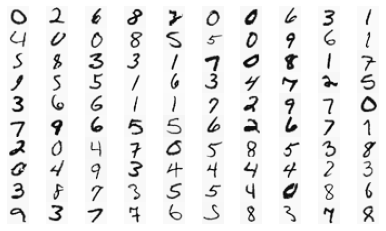

In [3]:
# Elegimos 100 ejemplos aleatorios y los mostramos
sample = np.random.choice(X.shape[0], 100)
asd = display.displayData(X[sample, :])

## Función de coste

Para calcular el coste, utilizaremos el algoritmo de propagación hacia delante. Para poder aplicar este algoritmo, debemos codificar el vector y para crear una matriz de 5000x10, que representan el número de ejemplos de entrenamiento y el número de etiqueta. En esta matriz, cada ejemplo contendrá un 1 en la columna correspondiente a su etiqueta y el resto todo 0. Este método se llama onehot, y hemos implementado una función que lo realiza.

In [4]:
# Calcula el valor de la función sigmoide
def sigmoid(X):
    z = 1/(1 + np.exp(-X))
    return z

In [5]:
# Propagación hacia delante
def forward_propagation(Theta1, Theta2, X):
    m = X.shape[0]

    # Input Layer
    a1 = np.hstack([np.ones([m, 1]), X])
    # Hidden Layer
    z2 = np.matmul(a1, Theta1.T)
    a2 = np.hstack([np.ones([m, 1]), sigmoid(z2)])
    # Output Layer
    z3 = np.matmul(a2, Theta2.T)
    a3 = sigmoid(z3)
    
    return a1, a2, a3

In [6]:
# Función de coste
def cost(Theta1, Theta2, X, y):
    a1, a2, H = forward_propagation(Theta1, Theta2, X)
    Term1 = y * np.log(H)
    Term2 =  (1 - y) * np.log(1 - H)
    coste = (- 1 / (len(y))) * np.sum(Term1 + Term2)

    return coste

In [7]:
# Función de coste con regularización
def cost_reg(Theta1, Theta2, X, y, lam):
    coste = cost(Theta1, Theta2, X, y)
    Term3 = np.sum(np.square(Theta1[:,1:])) + np.sum(np.square(Theta2[:,1:]))     
    coste += (lam / (2 * len(y))) * Term3
    
    return coste

In [8]:
# Calculo de onehot
def one_hot(y, num_etiquetas):
    m = len(y)
    y = (y - 1)
    y_onehot = np.zeros((m, num_etiquetas))
    
    for i in range(m):
        y_onehot[i][y[i]] = 1
    
    return y_onehot

### Resultados de los costes

Con los valores de las matrices Theta1 y Theta2, vamos a comprobar si nuestra función de coste, tanto regularizada como sin regularizar, realiza el cálculo correctamente. 

In [9]:
# Onehot 
y_onehot = one_hot(y, num_etiquetas)

# Debe salir 0.287629
coste = cost(Theta1, Theta2, X, y_onehot)
print("Coste sin regularizar: ", coste)

Coste sin regularizar:  0.2876291651613189


In [10]:
lam = 1

# Debe salir 0.383770
coste_reg = cost_reg(Theta1, Theta2, X, y_onehot, lam)
print("Coste regularizado: ", coste_reg)

Coste regularizado:  0.38376985909092365


## Cálculo del gradiente

Para calcular el gradiente vamos a utilizar el algoritmo de propagación hacia atrás sobre una red neuronal de tres capas. Nuestra función recibe los siguientes argumentos:
 - params_rn: contiene Theta1 y Theta2 como un array unidimensional
 - num_entradas: número de ejemplos de entrenamiento (número de neuronas en la primera capa)
 - num_ocultas: número de neuronas en la capa oculta
 - num_etiquetas: número de neuronas en la última capa
 - X: ejemplos de entrenamiento
 - y: etiquetas de los ejemplos
 - reg: término de regularización

In [11]:
# Función que calcula la propagación hacia atrás
def back_propagation(params_rn, num_entradas, num_ocultas, num_etiquetas, X, y, reg):
    
    # backprop devuelve una tupla (coste, gradiente) con el coste y el gradiente de
    # una red neuronal de tres capas, con num_entradas, num_ocultas nodos en la capa
    # oculta y num_etiquetas nodos en la capa de salida. Si m es el número de ejemplos
    # de entrenamiento, la dimensión de ’X’ es (m, num_entradas) y la de ’y’ es
    # (m, num_etiquetas)
    
    # Theta1 y Theta2 están codificados como un array unidimensional
    Theta1 = np.reshape(params_rn[:num_ocultas * (num_entradas + 1)], (num_ocultas, (num_entradas + 1)))
    Theta2 = np.reshape(params_rn[num_ocultas * (num_entradas + 1):], (num_etiquetas, (num_ocultas + 1)))
    
    m = len(y)
    
    # Matrices para almacenar el gradiente con las mismas dimensiones que Theta1 y Theta2
    Delta1 = np.zeros(np.shape(Theta1))
    Delta2 = np.zeros(np.shape(Theta2))
    
    # Propagación hacia delante
    a1, a2, H = forward_propagation(Theta1, Theta2, X)
    
    # Contribución de cada nodo al error de la salida
    d3 = H - y
    d2 = (np.dot(d3,Theta2) * (a2 * (1 - a2)))[:,1:]  
    Delta1 = np.dot(d2.T, a1)
    Delta2 = np.dot(d3.T, a2)
    
    # Añadimos regularización
    Delta1 = Delta1/m
    Delta2 = Delta2/m
    Delta1[:,1:] = Delta1[:,1:] + (reg/m)*Theta1[:,1:]
    Delta2[:,1:] = Delta2[:,1:] + (reg/m)*Theta2[:,1:]
    
    # Devolvemos el coste y el gradiente
    coste = cost_reg(Theta1, Theta2, X, y,reg)
    grad = np.concatenate((np.ravel(Delta1),np.ravel(Delta2)))
    
    return coste, grad 

### Comprobación del gradiente

Vamos a utilizar la función del archivo checkKNNGradients.py para compronar que el gradiente es correcto. 

In [12]:
# Comprobamos el descenso de gradiente y el coste
checkNN.checkNNGradients(back_propagation, lam)

grad shape:  (38,)
num grad shape:  (38,)


array([ 5.49965629e-11,  7.32747196e-13,  8.82988127e-12,  9.75091535e-12,
       -6.08260664e-11,  2.10970130e-12, -1.38742212e-11, -4.70332939e-11,
       -9.29989974e-11,  7.81530396e-12, -4.12793411e-11, -1.26643918e-10,
       -2.40059500e-11,  6.57690569e-12, -7.00919878e-12, -2.43030734e-11,
        2.15736456e-11,  2.27595720e-13,  9.77740111e-12,  2.84505197e-11,
        6.25964836e-11,  1.38673517e-11,  6.28552765e-12,  5.29279398e-12,
        1.58902475e-11,  1.56177293e-11,  6.93309299e-11,  1.41544554e-11,
        3.42380291e-12,  1.17110766e-11,  1.87037608e-11,  1.95246597e-11,
        7.55120411e-11,  1.66865410e-11,  6.33046393e-12,  1.85329807e-11,
        1.79033732e-11,  1.99839867e-11])

## Aprendizaje de los parámetros

Una vez comprobada la correción de cálculo de coste y el gradiente, vamos a utilizar scipy.optimize.minimize para entrenar la red neuronal y obtener los valores óptimos para Theta1 y Theta2. Para ello necesitamos pasarle el array de pesos inicializado, que los obtenemos de forma aleatoria en el rango [-eInit, eInit]. Hemos decidido probar con diferentes valores de regularización y número de iteraciones para observar la diferencia de los resultados.

In [13]:
# Entrena una red neuronal con reg como término de regularización y num_iters como número de iteraciones
def training(reg, num_iters):
    
    # Entrenamos la red neuronal
    fmin = minimize(fun=back_propagation, x0=params_rn,
                args=(num_entradas, num_ocultas,
                num_etiquetas, X, y_onehot, reg),
                method='TNC', jac=True,
                options={'maxiter': num_iters})

    # Reordenamos Theta1 y Theta2
    Theta1 = np.reshape(fmin.x[:num_ocultas*(num_entradas + 1)],(num_ocultas,(num_entradas + 1)))
    Theta2 = np.reshape(fmin.x[num_ocultas * (num_entradas+1):],(num_etiquetas,(num_ocultas + 1)))
    result = forward_propagation(Theta1,Theta2, X)[2]
    
    return result

In [14]:
# Calcula el porcentaje de aciertos de un resultado
def success_rate(resul):
    
    predicciones = []
    for i in range(len(result)):
        predicciones.append(np.argmax(result[i])+1)
    
    aciertos = 0
    for i in range(len(y)):
        if (predicciones[i] == y[i]):
            aciertos +=1
            
    return (aciertos/len(y)*100)

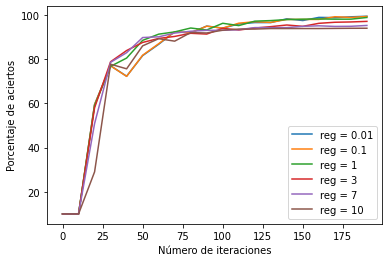

In [17]:
# Generamos valores aleatorios para Theta1 y Theta2
eInit = 0.12
Theta1 = np.random.random((num_ocultas,(num_entradas + 1)))*(2*eInit) - eInit
Theta2 = np.random.random((num_etiquetas,(num_ocultas + 1)))*(2*eInit) - eInit
params_rn = np.concatenate((np.ravel(Theta1), np.ravel(Theta2)))

# Diferentes valores de regularizacion y número de iteraciones
reg_terms = [0.01, 0.1, 1, 3, 7, 10]
iter_terms = np.arange(0, 200, 10)

for reg in reg_terms:
    porcentajes = []
    for iters in iter_terms:
        result = training(reg, iters)
        porcentajes.append(success_rate(result))
    
    # Pintamos la gráfica
    plt.plot(iter_terms, porcentajes, label='reg = ' + str(reg))

plt.xlabel("Número de iteraciones")
plt.ylabel("Porcentaje de aciertos")
plt.legend()
plt.show()

Aumentando el número de iteraciones, hay un mayor porcentaje de aciertos, al principio es bastante grande la diferencia pero a partir dde 50 iteraciones ya no varía demasiado. Consideramos que el valor óptimo estaría en torno a 100. En cuanto a los valores de regularización, cuanto mayor sea, mas rápido se estabiliza y deja de mejorar con el aumento de las iteraciones. 